In [1]:
using DifferentialEquations, Parameters, ParameterizedFunctions, LinearAlgebra
using BenchmarkTools, Test, CSV, DataFrames, FastGaussQuadrature, StaticArrays
using Plots, ColorSchemes
using Revise
using Base.Threads
using CSV,DataFrames

In [2]:
include("AtomInterferometrySims.jl")
using .AtomInterferometrySims

## import phasemap from GBP simulation
Here we consider a beam with 1cm diameter and a 80 cm free propagation after the aberration is introduced.
The aberration is introduced by clipping the beam at the center

In [3]:
phasemap_ab_prop = Matrix(CSV.read("phasemap_ab_1cm_prop80cm_20240602.csv",DataFrame;header=0));
phasemap_shear_prop = Matrix(CSV.read("phasemap_shear_1cm_prop80cm_20240602.csv",DataFrame;header=0));

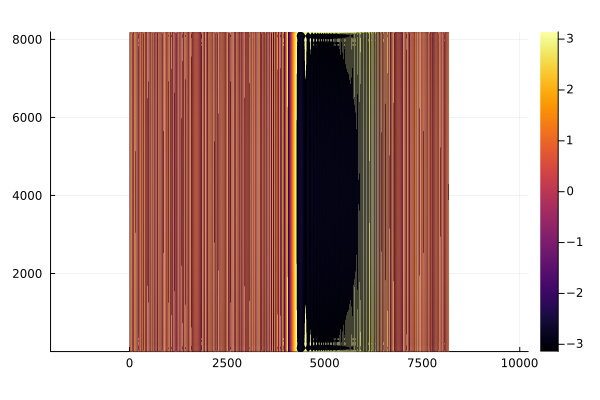

In [4]:
heatmap(phasemap_ab_prop,aspect_ratio = :equal)

## Full interferometer simulation
(no phase shear)

In [6]:
num = 5000

cloud_r = 1e-3
cloud_T = 8e-3

phase_out = Vector{Float64}(undef,num)
pos_out = Matrix{Float64}(undef,num,3)

atom_init_pos = init_pos(cloud_r,num)
atom_init_vel = init_vel(cloud_T,num)

Threads.@threads for i in 1:num
    r = atom_init_pos[i,:]
    v = atom_init_vel[i,:]
    phase_out_temp, pos_out_temp = atom_phase_path_int(r,v,0.,5e-3,1,phasemap_ab_prop,4e-2)
    phase_out[i] = phase_out_temp
    
    pos_out[i,:] = hcat(pos_out_temp)
    
end

## plot 2d distribution

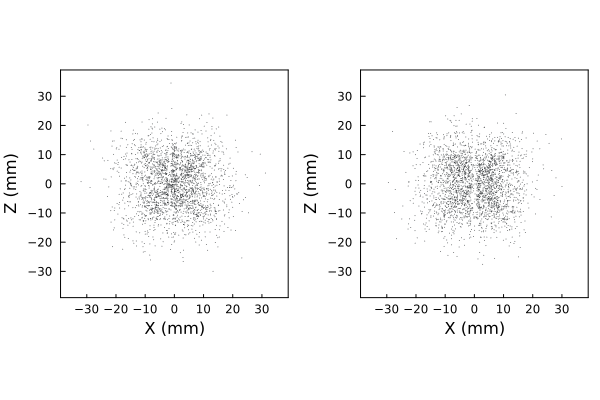

In [7]:
mask = [rand() > cos(x)^2 for x in phase_out]

final_pos = pos_out

zsig = -minimum(final_pos[:,2]) * 1e3 * 1.3 # rescale to mm, with 30% plot margin
prange = (-zsig,zsig)

p1 = scatter(
    final_pos[:,1][mask]*1e3,final_pos[:,2][mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false
)

p2 = scatter(
    final_pos[:,1][.!mask]*1e3,final_pos[:,2][.!mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false)


display(plot(p1,p2,layout = (1,2)))

## 1d distribution
(consider photon count for pixels)

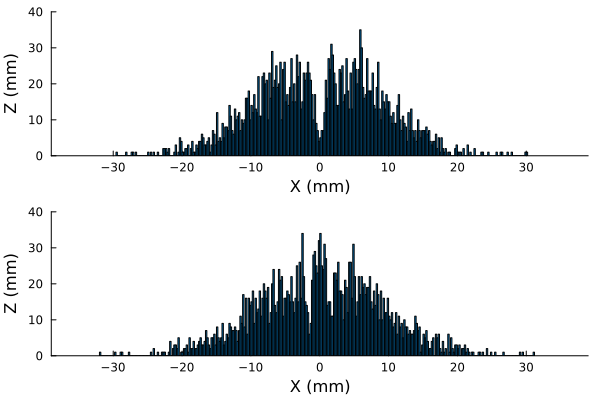

In [10]:
h1 = histogram(
    final_pos[:,1][.!mask]*1e3,
    xlims = prange,
    ylims = (0,40),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

h2 = histogram(
    final_pos[:,1][mask]*1e3,
    xlims = prange,
    ylims = (0,40),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

display(plot(h1,h2,layout = (2,1)))